# Comparing against OptaxSGD

This file shows how to use the scripts in Volterros.py to generate powerlaw random features loss curves.

In [1]:
import jax
import jax.numpy as jnp
import jax.random as random
import optax
import scipy as sp

from tqdm import tqdm

import Volterros
import matplotlib.pyplot as plt

key = random.PRNGKey(0)

In [2]:
ALPHA = 1.0
BETA = 0.7
V = 2000
D = 500
SGDBATCH=1
STEPS = 10**6

initialize_random creates an instance of the PLRF problem, i.e. with a sample of W, etc.

In [3]:
key, subkey = random.split(key)
problem = Volterros.power_law_RF.initialize_random(alpha=ALPHA, beta=BETA, v=V, d=D, key=subkey)


This implements DANA decay using the optax training loop.

In [4]:
g1 = Volterros.powerlaw_schedule(1.0, 0.0, 0.0, 1)
g2 = Volterros.powerlaw_schedule(0.5/problem.population_trace, 0.0, 0.0, 1)
g3 = Volterros.powerlaw_schedule(0.1/problem.population_trace, 0.0, -1.0/(2*problem.alpha), 1)
Delta = Volterros.powerlaw_schedule(1.0, 0.0, -1.0, 4.0+2*(problem.alpha+problem.beta)/(2*problem.alpha))
danadecayopt = Volterros.dana_optimizer(g1=g1,g2=g2,g3=g3,Delta=Delta)
#pls = powerlaw_schedule(0.5/problem.population_trace, 0.0, -0.5, 1)
key, newkey = random.split(key)
danadecaytimes,danadecaylosses = Volterros.lsq_streaming_optax_simple(newkey, 
                         problem.get_data, 
                         SGDBATCH, 
                         STEPS, 
                         danadecayopt, 
                         jnp.zeros((problem.d,1)), 
                         problem.get_population_risk)

100%|██████████| 130/130 [01:34<00:00,  1.37it/s]


Generate the rho weights empirically from the instence of the PLRF, and then solve the ODE using these weights.

In [5]:
#Initialize the rhos
initTheta = jnp.zeros(problem.d, dtype=jnp.float32)
initY = jnp.zeros(problem.d, dtype=jnp.float32)
rho_init = problem.get_rhos()
sigma_init = jnp.zeros_like(rho_init)
chi_init = jnp.zeros_like(rho_init)

Keigs = problem.get_hessian_spectra()
riskInftyTheory=problem.get_theory_limitloss()

Dt = 10**(-2)

odeTimes_dana_decay2, odeRisks_dana_decay2 = Volterros.ode_resolvent_log_implicit_full(
    Keigs.astype(jnp.float32), rho_init, chi_init, sigma_init, riskInftyTheory,
    g1, g2, g3, Delta, 
    SGDBATCH, problem.d, STEPS, Dt)


Generate rho weights using the random matrix theory formulation.

In [8]:

#Compute the theoretical limiting loss value
riskInftyTheory = Volterros.power_law_RF.theory_limitloss(ALPHA, BETA, V, D)
print('Theoretical limiting loss value is {}'.format(riskInftyTheory))

# Compute theoretical integrals using density approximation
lower_bound = Volterros.power_law_RF.theory_lambda_min(ALPHA)*(D**(-2*ALPHA)) #jnp.minimum(0.00001, 0.9*(D+1)**(-2.0*alpha)) #tt_lmin(alpha)*(D**(-2*alpha)) #jnp.minimum(0.00001, 0.9*(D+1)**(-2.0*alpha))
upper_bound = 1.0*1.1


fake_eigs = jnp.power(jnp.arange(1,D+1,dtype=jnp.float32),-2.0*ALPHA)
b_values = fake_eigs - 0.5 * jnp.diff(fake_eigs, prepend = upper_bound)
a_values = fake_eigs + 0.5 * jnp.diff(fake_eigs, append = lower_bound)


num_splits = 5
rho_weights = problem.get_theory_rho_weights(num_splits, a_values, b_values)

print('Initial loss value is is {}'.format(jnp.sum( rho_weights*fake_eigs) + riskInftyTheory))


rho_init = rho_weights #density * dx
num_grid_points = D
sigma_init = jnp.zeros(num_grid_points, dtype=jnp.float32)
chi_init = jnp.zeros(num_grid_points, dtype=jnp.float32)

Dt = 10**(-2) #10**(-2)


odeTimes_dana_decay_theory, odeRisks_dana_decay_theory = Volterros.ode_resolvent_log_implicit_full(
    fake_eigs, rho_init, chi_init, sigma_init, riskInftyTheory,
    g1, g2, g3, Delta, SGDBATCH, num_grid_points, STEPS, Dt)


Theoretical limiting loss value is 2.2151913071866147e-05
Initial loss value is is 0.9775581359863281


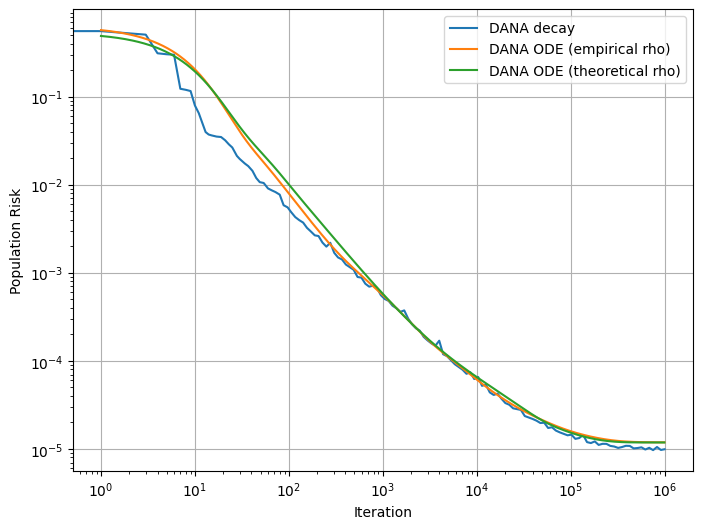

In [9]:
plt.figure(figsize=(8,6))
plt.loglog(danadecaytimes,danadecaylosses,label='DANA decay')
plt.loglog(odeTimes_dana_decay2, odeRisks_dana_decay2, label='DANA ODE (empirical rho)')
plt.loglog(odeTimes_dana_decay_theory, odeRisks_dana_decay_theory, label='DANA ODE (theoretical rho)')
plt.xlabel('Iteration')
plt.ylabel('Population Risk')
plt.legend()
plt.grid(True)

# Section  SGD unit test

This runs the training loop for 10**6 steps.  This code ensures that the optax routine is working when compared to the previous JAX optimizer implementation.

In [12]:
def jax_lsq_momentum1(key,
                g1, g2, g3, delta, batch, steps, init_x, init_w,
                t_oracle, loss, loss_times = jnp.array([0])
                ):
  """ This routine generates losses for SGD on the least squares
  problem with scalar targets, constant learning rate and constant batch size.

  Parameters
  ----------
  key : PRNGKey
    Jax PRNGKey
  g1, g2, g3 : function(time)
    The learning rate functions
  delta : function(time)
    The momentum function
  batch : int
    The batch-size to use
  steps : int
    The number of steps of minibatch SGD to generate
  init_x : vector
    The initial state for SGD to use
  init_w : vector
    The initial state for momentum
  traceK : float
    Trace of the covariance matrix of the data; i.e., K = E[aa^T]
  t_oracle: callable
    Takes as an argument a jax RNG key and a batch-size.
    Expects in return two tensors (A, y)
    of dimension (batch x data-dimension) and dimension (batch).
  loss: callable
    Takes as an argument a vector of length data-dimension,
    which is the current linear model parameters, and returns the
    loss.
  loss_times: vector
    Iteration counts at which to compute the loss

  Returns
  -------
  losses: vector
    An array of length 'steps' containing the losses
  loss_times: vector
    Iteration counts at which the losses were computed
  """

  if loss_times.shape[0]==1:
    loss_times = jnp.arange(steps)
  x = jnp.reshape(init_x,(len(init_x),1))
  w = jnp.reshape(init_w,(len(init_w),1))


  def update(z, things):
    keyz, iteration = things
    A,y = t_oracle(keyz, batch)
    x,w = z
    grad = jnp.tensordot(A,jnp.tensordot(A,x,axes=1)-y,axes=[[0],[0]])
    neww = (1.0 - delta(iteration)) * w + g1(iteration) * grad
    newx = x - g2(iteration) * grad - neww * g3(iteration)
    return (newx,neww), x

  keys=jax.random.split(key,steps)
  iters =  jnp.linspace(0.0, steps, num = steps)


 # update_jit = jax.jit(update)
  _, states = jax.lax.scan(update,(x,w),(keys,iters))

  return jax.lax.map(loss, states[loss_times[loss_times< steps]]), loss_times[loss_times< steps], states[-1]

In [11]:
key, newkey = random.split(key)
plainSGD = optax.sgd(learning_rate=0.5/problem.population_trace)
sgd_times,sgd_losses = Volterros.lsq_streaming_optax_simple(newkey, 
                         problem.get_data, 
                         SGDBATCH, 
                         STEPS, 
                         plainSGD, 
                         jnp.zeros((problem.d,1)), 
                         problem.get_population_risk)

100%|██████████| 130/130 [01:29<00:00,  1.45it/s]


Compute the same results using the previous JAX code.

In [13]:
#Code for running pure SGD
sgd_gamma_2_constant = 0.5
sgd_gamma_2_scaling = sgd_gamma_2_constant / problem.population_trace
def g2_sgd(time):
  return sgd_gamma_2_scaling * jnp.ones_like(time)
def g1_sgd(time):
  return 0.0
def g3_sgd(time):
  return 0.0
def delta_sgd(time):
  return 0.0

key,nkey = jax.random.split(key)

sgd_losses_jax, sgd_times_jax, sgd_theta_jax_final = jax_lsq_momentum1(nkey,
                g1_sgd, g2_sgd, g3_sgd, delta_sgd, 1, 10**5, 
                jnp.zeros(problem.d),jnp.zeros(problem.d),
                problem.get_data,problem.get_population_risk
                )


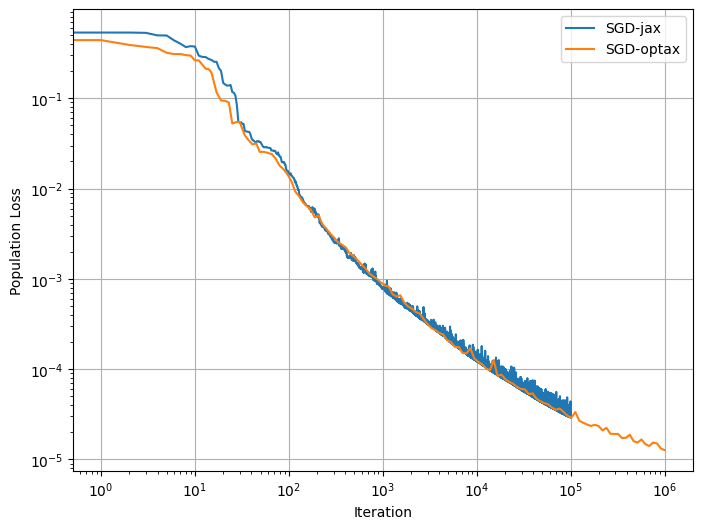

In [14]:
plt.figure(figsize=(8,6))
plt.loglog(sgd_times_jax, sgd_losses_jax, label='SGD-jax')
plt.loglog(sgd_times, sgd_losses, label='SGD-optax')
plt.xlabel('Iteration')
plt.ylabel('Population Loss')
plt.grid(True)
plt.legend()
plt.show()